# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Нужно проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error

from sklearn.utils import shuffle

### Загружаем датасеты

In [3]:
df1 = pd.read_csv('geo_data_0.csv')
display(df1.head())
print(df1.info())

df2 = pd.read_csv('geo_data_1.csv')
display(df2.head())
print(df2.info())

df3 = pd.read_csv('geo_data_2.csv')
display(df3.head())
print(df3.info())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


### Проверка на дубликаты

In [4]:
print('Количество дубликатов в первом датафрейме:',df1.duplicated().sum())
print('Количество дубликатов во втором датафрейме:',df2.duplicated().sum())
print('Количество дубликатов в третьем датафрейме:',df3.duplicated().sum())

Количество дубликатов в первом датафрейме: 0
Количество дубликатов во втором датафрейме: 0
Количество дубликатов в третьем датафрейме: 0


#### Неявные дубликаты

In [5]:
display(df1[df1.duplicated(subset='id')])
display(df2[df2.duplicated(subset='id')])
display(df3[df3.duplicated(subset='id')])

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


В каждом датасете присутствуют дубликаты по столбцу id. Т.к. их количество невелико, а значения признаков отличаются, их можно оставить.

### Посмотрим на корреляцию признаков

Столбец id нам не пригодится, сразу же исключим его.

In [5]:
df1 = df1.drop('id', axis=1)
df2 = df2.drop('id', axis=1)
df3 = df3.drop('id', axis=1)

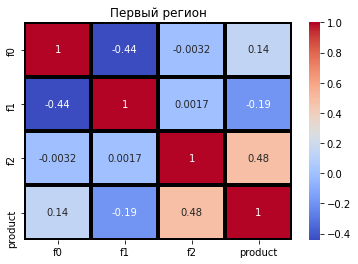

In [6]:
sns.heatmap(df1.corr(), xticklabels=df1.columns, yticklabels=df1.columns,cmap= 'coolwarm', linewidths=3,\
            linecolor='black', annot = True).set_title('Первый регион');

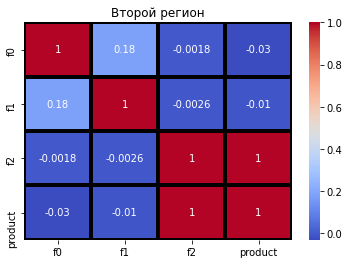

In [7]:
sns.heatmap(df2.corr(), xticklabels=df2.columns, yticklabels=df2.columns,cmap= 'coolwarm', linewidths=3,\
            linecolor='black', annot = True).set_title('Второй регион');

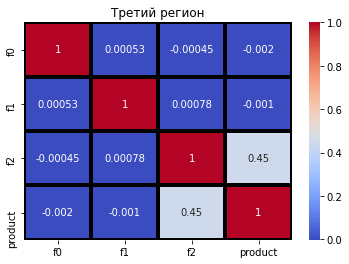

In [8]:
sns.heatmap(df3.corr(), xticklabels=df3.columns, yticklabels=df3.columns,cmap= 'coolwarm', linewidths=3,\
            linecolor='black', annot = True).set_title('Третий регион');

Видим сильную корреляцию между признаком f2 и целевым признаком во втором регионе. Это хорошо, модель для этого региона будет точнее.

### Преобразуем типы для экономии памяти

In [9]:
numeric_float = ['f0', 'f1', 'f2', 'product']
for i in numeric_float:
    df1[i] = pd.to_numeric(df1[i], downcast='float')
    df2[i] = pd.to_numeric(df2[i], downcast='float')
    df3[i] = pd.to_numeric(df3[i], downcast='float')
    
print(df1.info())
print(df2.info())
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float32
 1   f1       100000 non-null  float32
 2   f2       100000 non-null  float32
 3   product  100000 non-null  float32
dtypes: float32(4)
memory usage: 1.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float32
 1   f1       100000 non-null  float32
 2   f2       100000 non-null  float32
 3   product  100000 non-null  float32
dtypes: float32(4)
memory usage: 1.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float3

### Определим признаки и целевой признак

Столбец id с идетификатором скважины нам не нужен. Признаки - f0, f1, f2. Целевой признак - product.

In [10]:
features1 = df1.drop('product', axis=1)
features2 = df2.drop('product', axis=1)
features3 = df3.drop('product', axis=1)

target1 = df1['product']
target2 = df2['product']
target3 = df3['product']

### Разделим данные на тренировочную и валидационную выборки

Тренировочная - 75%, валидационная - 25%.

In [11]:
state = np.random.RandomState(12345)

def split(features, target):
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, train_size=0.75, random_state=state)
    print('Размер тренировочной выборки с признаками:', features_train.shape)
    print('Размер валидационной выборки с признаками:', features_valid.shape)
    print('Размер тренировочной выборки с целевым признаком:', target_train.shape)
    print('Размер валидационной выборки с целевым признаком:', target_valid.shape)
    print()
    return features_train, features_valid, target_train, target_valid

In [12]:
print('1 регион')
features_train1, features_valid1, target_train1, target_valid1 = split(features1, target1)

print('2 регион')
features_train2, features_valid2, target_train2, target_valid2 = split(features2, target2)

print('3 регион')
features_train3, features_valid3, target_train3, target_valid3 = split(features3, target3)

1 регион
Размер тренировочной выборки с признаками: (75000, 3)
Размер валидационной выборки с признаками: (25000, 3)
Размер тренировочной выборки с целевым признаком: (75000,)
Размер валидационной выборки с целевым признаком: (25000,)

2 регион
Размер тренировочной выборки с признаками: (75000, 3)
Размер валидационной выборки с признаками: (25000, 3)
Размер тренировочной выборки с целевым признаком: (75000,)
Размер валидационной выборки с целевым признаком: (25000,)

3 регион
Размер тренировочной выборки с признаками: (75000, 3)
Размер валидационной выборки с признаками: (25000, 3)
Размер тренировочной выборки с целевым признаком: (75000,)
Размер валидационной выборки с целевым признаком: (25000,)



### Выполним масштабирование признаков

Применим стандартизацию, чтобы модели считали все признаки одинаково значимыми.

In [13]:
numeric = ['f0', 'f1', 'f2']

pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train1[numeric])

features_train1[numeric] = scaler.transform(features_train1[numeric])
features_valid1[numeric] = scaler.transform(features_valid1[numeric])

scaler.fit(features_train2[numeric])

features_train2[numeric] = scaler.transform(features_train2[numeric])
features_valid2[numeric] = scaler.transform(features_valid2[numeric])

scaler.fit(features_train3[numeric])

features_train3[numeric] = scaler.transform(features_train3[numeric])
features_valid3[numeric] = scaler.transform(features_valid3[numeric])

## Обучение и проверка модели

Будем использовать модель линейной регрессии.

### Модель для 1 региона

In [14]:
model1 = LinearRegression(n_jobs=-1)
model1.fit(features_train1, target_train1)
predictions_valid1 = model1.predict(features_valid1)
predicted_mean1 = predictions_valid1.sum() / len(predictions_valid1)

print('Средний запас предсказанного сырья', predicted_mean1)
print('RMSE:', (mean_squared_error(target_valid1, predictions_valid1) ** 0.5))

Средний запас предсказанного сырья 92.59258
RMSE: 37.57941948134228


#### Проверка модели

Используем DummyRegressor, который будет предсказывать среднее.

In [15]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train1, target_train1)
dummy_pred_valid1 = dummy.predict(features_valid1)
print('RMSE dummy:', (mean_squared_error(target_valid1, dummy_pred_valid1) ** 0.5))

RMSE dummy: 44.28959237974608


### Модель для 2 региона

In [16]:
model2 = LinearRegression(n_jobs=-1)
model2.fit(features_train2, target_train2)
predictions_valid2 = model2.predict(features_valid2)
predicted_mean2 = predictions_valid2.sum() / len(predictions_valid2)

print('Средний запас предсказанного сырья', predicted_mean2)
print('RMSE:', (mean_squared_error(target_valid2, predictions_valid2) ** 0.5))

Средний запас предсказанного сырья 68.76995
RMSE: 0.889736870433275


#### Проверка модели

In [17]:
dummy.fit(features_train2, target_train2)
dummy_pred_valid2 = dummy.predict(features_valid2)
print('RMSE dummy:', (mean_squared_error(target_valid2, dummy_pred_valid2) ** 0.5))

RMSE dummy: 46.037555788385966


### Модель для 3 региона

In [18]:
model3 = LinearRegression(n_jobs=-1)
model3.fit(features_train3, target_train3)
predictions_valid3 = model3.predict(features_valid3)
predicted_mean3 = predictions_valid3.sum() / len(predictions_valid3)

print('Средний запас предсказанного сырья', predicted_mean3)
print('RMSE:', (mean_squared_error(target_valid3, predictions_valid3) ** 0.5))

Средний запас предсказанного сырья 95.08753
RMSE: 39.9580422643748


#### Проверка модели

In [19]:
dummy.fit(features_train3, target_train3)
dummy_pred_valid3 = dummy.predict(features_valid3)
print('RMSE dummy:', (mean_squared_error(target_valid3, dummy_pred_valid3) ** 0.5))

RMSE dummy: 44.74889794383209


### Промежуточный вывод

- Все модели проходят проверку на адекватность;

- Наибольший средний запас предсказанного сырья у 3 региона - 95 тысяч баррелей;

- Наименьшая ошибка у модели для 2 региона - 0.89, но средний предсказанный запас в этом регионе меньше всего.

## Подготовка к расчёту прибыли

### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [20]:
BUDGET = 10000000000 # бюджет на разработку
PRODUCT_PRICE = 450000 # за тысячу баррелей (единицу продукта)
POINTS_DEV = 500 # количество точек, выбранных для исследования
POINTS_CHOSEN = 200 # количество точек, выбранных для разработки
POINT_PRICE = BUDGET / POINTS_CHOSEN
POINT_TRESHOLD = POINT_PRICE / PRODUCT_PRICE

print('Необходимый запас сырья для безубыточной разработки скважины', POINT_TRESHOLD)

Необходимый запас сырья для безубыточной разработки скважины 111.11111111111111


### Сравним со средним запасом в каждом регионе

In [21]:
print('Средний объем запасов скважины в 1-м регионе: ', df1['product'].mean())
print('Средний объем запасов скважины в 2-м регионе: ', df2['product'].mean())
print('Средний объем запасов скважины в 3-м регионе: ', df3['product'].mean())

Средний объем запасов скважины в 1-м регионе:  92.5
Средний объем запасов скважины в 2-м регионе:  68.825
Средний объем запасов скважины в 3-м регионе:  95.0


In [22]:
print(df1['product'].describe())
print()
print(df2['product'].describe())
print()
print(df3['product'].describe())

count    100000.000000
mean         92.500000
std          44.288692
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564087
max         185.364349
Name: product, dtype: float64

count    100000.000000
mean         68.824997
std          45.944424
min           0.000000
25%          26.953260
50%          57.085625
75%         107.813042
max         137.945404
Name: product, dtype: float64

count    100000.000000
mean         95.000000
std          44.749920
min           0.000000
25%          59.450439
50%          94.925613
75%         130.595024
max         190.029831
Name: product, dtype: float64


In [23]:
print(df2['product'].quantile(0.80))

110.99214935302734


### Промежуточный вывод

На первый взгляд, средних запасов не достаточно для прохождения порога безубыточной разработки. Однако, если посмотреть на 75% квантили, то можно заметить, что в 1 и 3 регионах 25% скважин имеют необходимый запас. Учитывая объемы выборок, это 25 тысяч скважин. У второго региона - около 20 тысяч.

Все регионы потенциально подходят для разработки.

## Расчёт прибыли и рисков 

### Функция расчета прибыли

#### Сбрасываем индексы

In [24]:
target_valid1 = target_valid1.reset_index(drop=True)
target_valid2 = target_valid2.reset_index(drop=True)
target_valid3 = target_valid3.reset_index(drop=True)

#### Пишем функцию для расчетов

In [25]:
def revenue(target, predictions1):
    predictions1 = predictions1.reset_index(drop=True)
    target = target.reset_index(drop=True)
    
    pred_sorted = predictions1.sort_values(ascending=False)
    selected = target[pred_sorted.index][:POINTS_CHOSEN]



    # КОД РЕВЬЮЕРА, debug
    if target[pred_sorted.index].shape[0] != pred_sorted.shape[0]:
        print("Shape mismatch! Selected targets shape:", target[pred_sorted.index].shape)


    result = selected.sum()*PRODUCT_PRICE - BUDGET
    return result

#### Выводим результаты

In [28]:
print('Предсказанная прибыль с 200 лучших скважин 1 региона',round(revenue(target_valid1, pd.Series(predictions_valid1)), 2))
print('Предсказанная прибыль с 200 лучших скважин 2 региона', round(revenue(target_valid2, pd.Series(predictions_valid2)), 2))
print('Предсказанная прибыль с 200 лучших скважин 3 региона', round(revenue(target_valid3, pd.Series(predictions_valid3)), 2))

Предсказанная прибыль с 200 лучших скважин 1 региона 3320826171.88
Предсказанная прибыль с 200 лучших скважин 2 региона 2415088671.88
Предсказанная прибыль с 200 лучших скважин 3 региона 2539916210.94


### Считаем риски и прибыль для каждого региона

Напишем функцию bootstrap для получения распределения прибыли, подсчета доверительного интервала и риска убытков.

In [29]:
def bootstrap(target_valid, predictions_valid):
    state = np.random.RandomState(12345)
    values = []
    
    for i in range(1000):
        target_subsample = target_valid.sample(POINTS_DEV, replace=True, random_state=state)
        predictions_subsample = predictions_valid[target_subsample.index]
        
        values.append(revenue(target_subsample, predictions_subsample))

    values = pd.Series(values)
    
    lower = round(values.quantile(0.025), 2)
    upper = round(values.quantile(0.975), 2)
    mean = values.mean()
    
    h = sns.histplot(values)
    plt.xlabel('млрд. руб.')
    plt.ylabel('')
    plt.axvline(x=lower, color='green')
    plt.axvline(x=upper, color='green')
    
    print('Средняя прибыль:', round(mean, 2))
    print('95% доверительный интервал: от', lower, 'до', upper)
    print('Риск убытков:', round(values[values<0].count() / values.count() * 100, 2), '%')

#### Регион 1

Средняя прибыль: 396164978.81
95% доверительный интервал: от -111215019.53 до 909767150.88
Риск убытков: 6.9 %


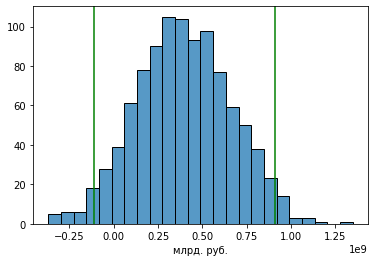

In [32]:
bootstrap(target_valid1, pd.Series(predictions_valid1))

#### Регион 2

Средняя прибыль: 445618806.35
95% доверительный интервал: от 54586030.27 до 833069660.64
Риск убытков: 1.1 %


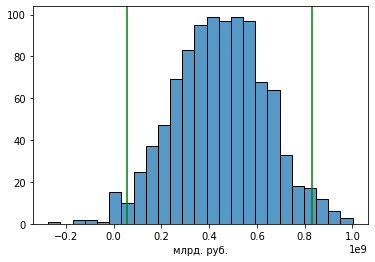

In [33]:
bootstrap(target_valid2, pd.Series(predictions_valid2))

#### Регион 3

Средняя прибыль: 340026911.04
95% доверительный интервал: от -208030102.54 до 868855493.16
Риск убытков: 10.7 %


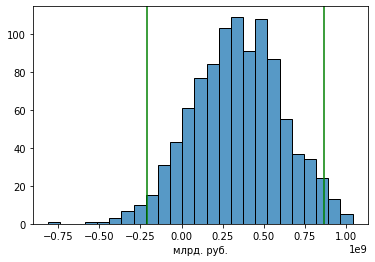

In [34]:
bootstrap(target_valid3, pd.Series(predictions_valid3))

## Вывод

Мы изучили данные по скважинам в трех регионах нефтедобычи. На основе данных о пробах нефти, нам необходимо было определить регион, в котором будут разрабатываться новые скважины.

На этапе **подготовки данных** мы загрузили датасеты и подготовили данные к исследованию. Проверили на пропуски, определили признаки и целевой признак. Получили валидационные и тестовые выборки, выполнили масштабирование численных признаков.

На этапе **обучения моделей** мы создали и обучили модели для каждого региона, предсказывающие запас сырья. Наибольший средний запас предсказанного сырья у 3 региона - 95 тысяч баррелей, однако, наименьшая ошибка у модели для 2 региона - 0.89, но в этом регионе средний предсказанный запас оказался меньше всего.

При **подготовке к расчёту прибыли** мы выполнили следующие действия:
- рассчитали достаточный объём сырья для безубыточной разработки новой скважины - 112 тысяч баррелей;
- сравнили со средними запасами в каждом регионе: средних запасов недостаточно, однако, учитывая объемы данных, в каждом регионе хватает скважин с высокими запасам, это видно при взгляде на 75% квантили;

После **рассчета прибыли и рисков** можно сделать следующие выводы:
- для разработки рекомендуется второй регион;
- по итогам исследования, средняя прибыль второго региона выше, чем у остальных;
- это единственный регион, с удовлетворительными показателями вероятности убытков - 1.1%
- модель для этого региона обучилась лучше остальных и дает наименьшую ошибку, что может быть полезно в дальнейших исследованиях;